# Requirements

In [5]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.nn import GCNConv, Set2Set, GNNExplainer
import torch_geometric.transforms as T
import torch
import torch.nn
import torch.nn.functional as F
import os
from tqdm import tqdm, trange
from torch_geometric.utils.convert import from_networkx
from sklearn.model_selection import train_test_split
import networkx as nx
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
import torch_geometric.utils.convert
from torch_geometric.utils.convert import from_networkx
import networkx as nx
import matplotlib.pyplot as plt
import category_encoders as ce
from matplotlib.pyplot import figure
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# Data pre-processing

In [6]:
filename = "NF-ToN-IoT.csv"
data = pd.read_csv(filename)

#data0 = dataPSA[dataPSA['Label'] == 0].head(n=50000)
#data1 = dataPSA[dataPSA['Label'] == 1].head(n=50000)
#dataPSA = pd.concat([data0, data1], ignore_index=True)

In [7]:
data

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,192.168.1.195,63318,52.139.250.253,443,6,91.00,181,165,2,1,24,327,0,Benign
1,192.168.1.79,57442,192.168.1.255,15600,17,0.00,63,0,1,0,0,0,0,Benign
2,192.168.1.79,57452,239.255.255.250,15600,17,0.00,63,0,1,0,0,0,0,Benign
3,192.168.1.193,138,192.168.1.255,138,17,10.16,472,0,2,0,0,0,0,Benign
4,192.168.1.79,51989,192.168.1.255,15600,17,0.00,63,0,1,0,0,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379269,192.168.1.31,58032,192.168.1.194,80,6,7.00,216,180,4,3,18,9433,1,ddos
1379270,192.168.1.31,58034,192.168.1.194,80,6,7.00,216,180,4,3,18,9221,1,ddos
1379271,192.168.1.31,58036,192.168.1.194,80,6,7.00,216,180,4,3,18,9656,1,ddos
1379272,192.168.1.31,58038,192.168.1.194,80,6,7.00,216,180,4,3,18,10046,1,ddos


In [8]:
print(data.shape)

(1379274, 14)


<Figure size 3000x3000 with 0 Axes>

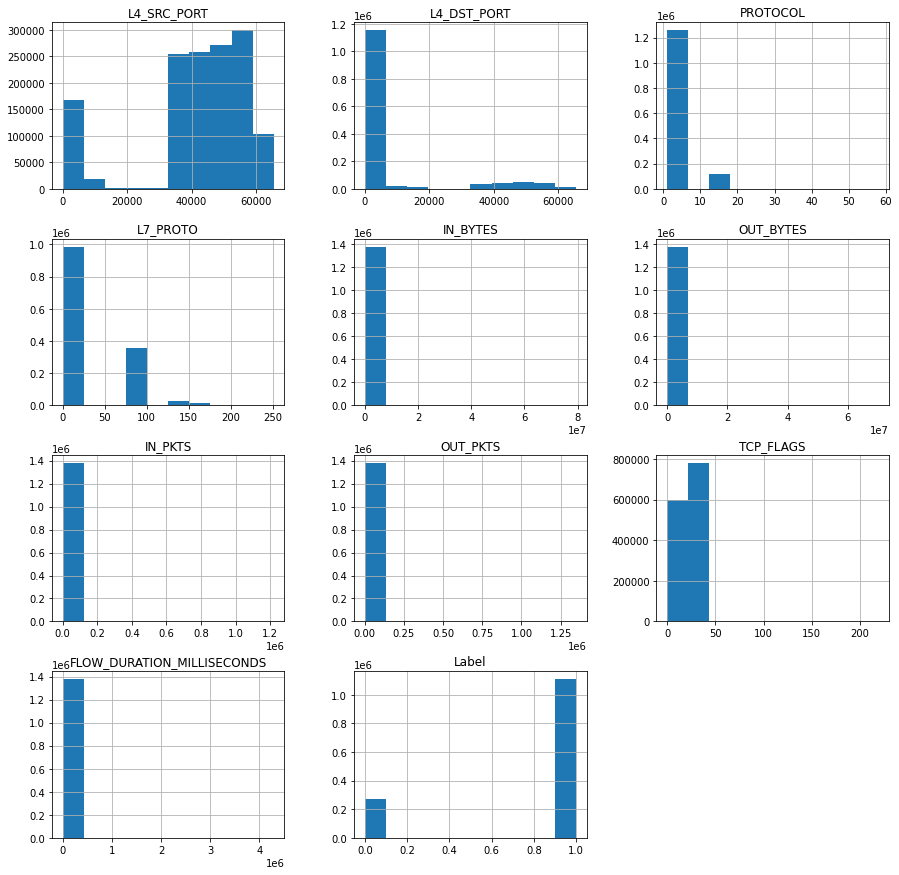

In [9]:
# print histogram for each parameter

figure(figsize=(15, 15), dpi=200)
data.hist(figsize=(15,15))



plt.show()    

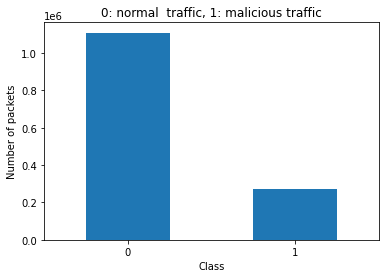

In [10]:
count_classes = pd.value_counts(data['Label'], sort = True)
count_classes.plot(kind = 'bar', rot=0)


plt.xticks(range(len(data['Label'].unique())), data.Label.unique())
plt.title("0: normal  traffic, 1: malicious traffic")
plt.xlabel("Class")
plt.ylabel("Number of packets");

In [11]:
dataPSA=data
dataPSA['IPV4_SRC_ADDR'] = dataPSA.IPV4_SRC_ADDR.apply(str)
dataPSA['L4_SRC_PORT'] = dataPSA.L4_SRC_PORT.apply(str)
dataPSA['IPV4_DST_ADDR'] = dataPSA.IPV4_DST_ADDR.apply(str)
dataPSA['L4_DST_PORT'] = dataPSA.L4_DST_PORT.apply(str)

#dataPSA["id"]=dataPSA.index.tolist()
#dataPSA["id"]=dataPSA.id.apply(str)

dataPSA['IPV4_SRC'] = dataPSA['IPV4_SRC_ADDR'].apply(lambda x: int(x.split('.')[0]))##############
dataPSA['IPV4_DST'] = dataPSA['IPV4_DST_ADDR'].apply(lambda x: int(x.split('.')[0]))##############

dataPSA['IPV4_SRC_ADDR'] = dataPSA['IPV4_SRC_ADDR'] + ':' + dataPSA['L4_SRC_PORT'] # + ':' + dataPSA["id"]
dataPSA['IPV4_DST_ADDR'] = dataPSA['IPV4_DST_ADDR'] + ':' + dataPSA['L4_DST_PORT'] # + ':' + dataPSA["id"]
#dataPSA.drop(columns=['L4_SRC_PORT','L4_DST_PORT'],inplace=True)

Label=dataPSA.Label

dataPSA.drop(columns=['Attack','Label'],inplace = True)
#dataPSA.drop(columns=['id'],inplace = True)


cols_to_norm =  list(set(list(dataPSA.iloc[:,:].columns ))  - set(list(['Label','IPV4_DST_ADDR','IPV4_SRC_ADDR','IPV4_SRC','IPV4_DST'])) )
#cols_to_norm= list([ 'L4_SRC_PORT', 'L4_DST_PORT','PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS','TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS' ])
scaler = StandardScaler()
dataPSA[cols_to_norm] = scaler.fit_transform(dataPSA[cols_to_norm])

data=  dataPSA
data['x'] = data[ cols_to_norm ].values.tolist()
data['y']= Label
#data = data.sample(frac=1)

In [12]:
data

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,IPV4_SRC,IPV4_DST,x,y
0,192.168.1.195:63318,1.245968,52.139.250.253:443,-0.397218,-0.301000,1.441053,-0.007222,-0.023340,-0.005547,-0.006677,0.339686,-0.052673,192,52,"[-0.3972184652275329, -0.006677072951932095, -...",0
1,192.168.1.79:57442,0.913593,192.168.1.255:15600,0.508398,3.164067,-0.784838,-0.007885,-0.024832,-0.005894,-0.007365,-2.588567,-0.055405,192,192,"[0.5083977770499875, -0.007364610647652972, -0...",0
2,192.168.1.79:57452,0.914159,239.255.255.250:15600,0.508398,3.164067,-0.784838,-0.007885,-0.024832,-0.005894,-0.007365,-2.588567,-0.055405,192,239,"[0.5083977770499875, -0.007364610647652972, -0...",0
3,192.168.1.193:138,-2.327794,192.168.1.255:138,-0.415442,3.164067,-0.536321,-0.005587,-0.024832,-0.005547,-0.007365,-2.588567,-0.055405,192,192,"[-0.41544192329275975, -0.007364610647652972, ...",0
4,192.168.1.79:51989,0.605145,192.168.1.255:15600,0.508398,3.164067,-0.784838,-0.007885,-0.024832,-0.005894,-0.007365,-2.588567,-0.055405,192,192,"[0.5083977770499875, -0.007364610647652972, -0...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379269,192.168.1.31:58032,0.946966,192.168.1.194:80,-0.418907,-0.301000,-0.613615,-0.007025,-0.023204,-0.004854,-0.005302,-0.392377,0.023380,192,192,"[-0.4189073677772947, -0.005301997560490341, -...",1
1379270,192.168.1.31:58034,0.947079,192.168.1.194:80,-0.418907,-0.301000,-0.613615,-0.007025,-0.023204,-0.004854,-0.005302,-0.392377,0.021609,192,192,"[-0.4189073677772947, -0.005301997560490341, -...",1
1379271,192.168.1.31:58036,0.947193,192.168.1.194:80,-0.418907,-0.301000,-0.613615,-0.007025,-0.023204,-0.004854,-0.005302,-0.392377,0.025242,192,192,"[-0.4189073677772947, -0.005301997560490341, -...",1
1379272,192.168.1.31:58038,0.947306,192.168.1.194:80,-0.418907,-0.301000,-0.613615,-0.007025,-0.023204,-0.004854,-0.005302,-0.392377,0.028500,192,192,"[-0.4189073677772947, -0.005301997560490341, -...",1


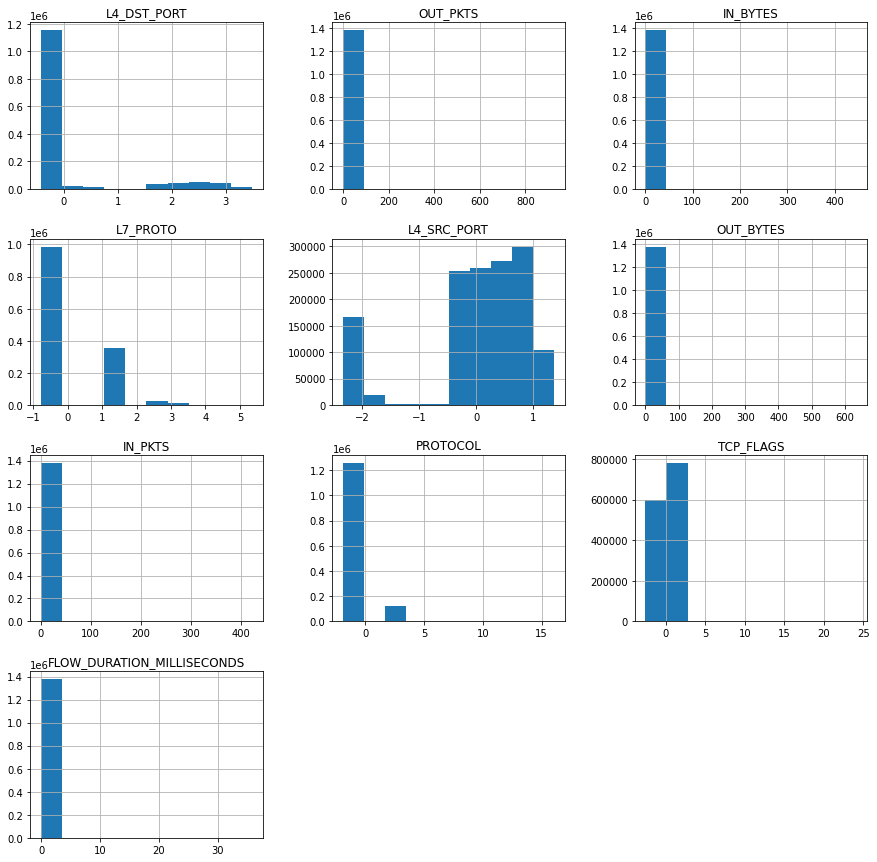

In [17]:
data[cols_to_norm].hist(figsize=(15,15))
plt.show()

In [14]:
import seaborn as sns

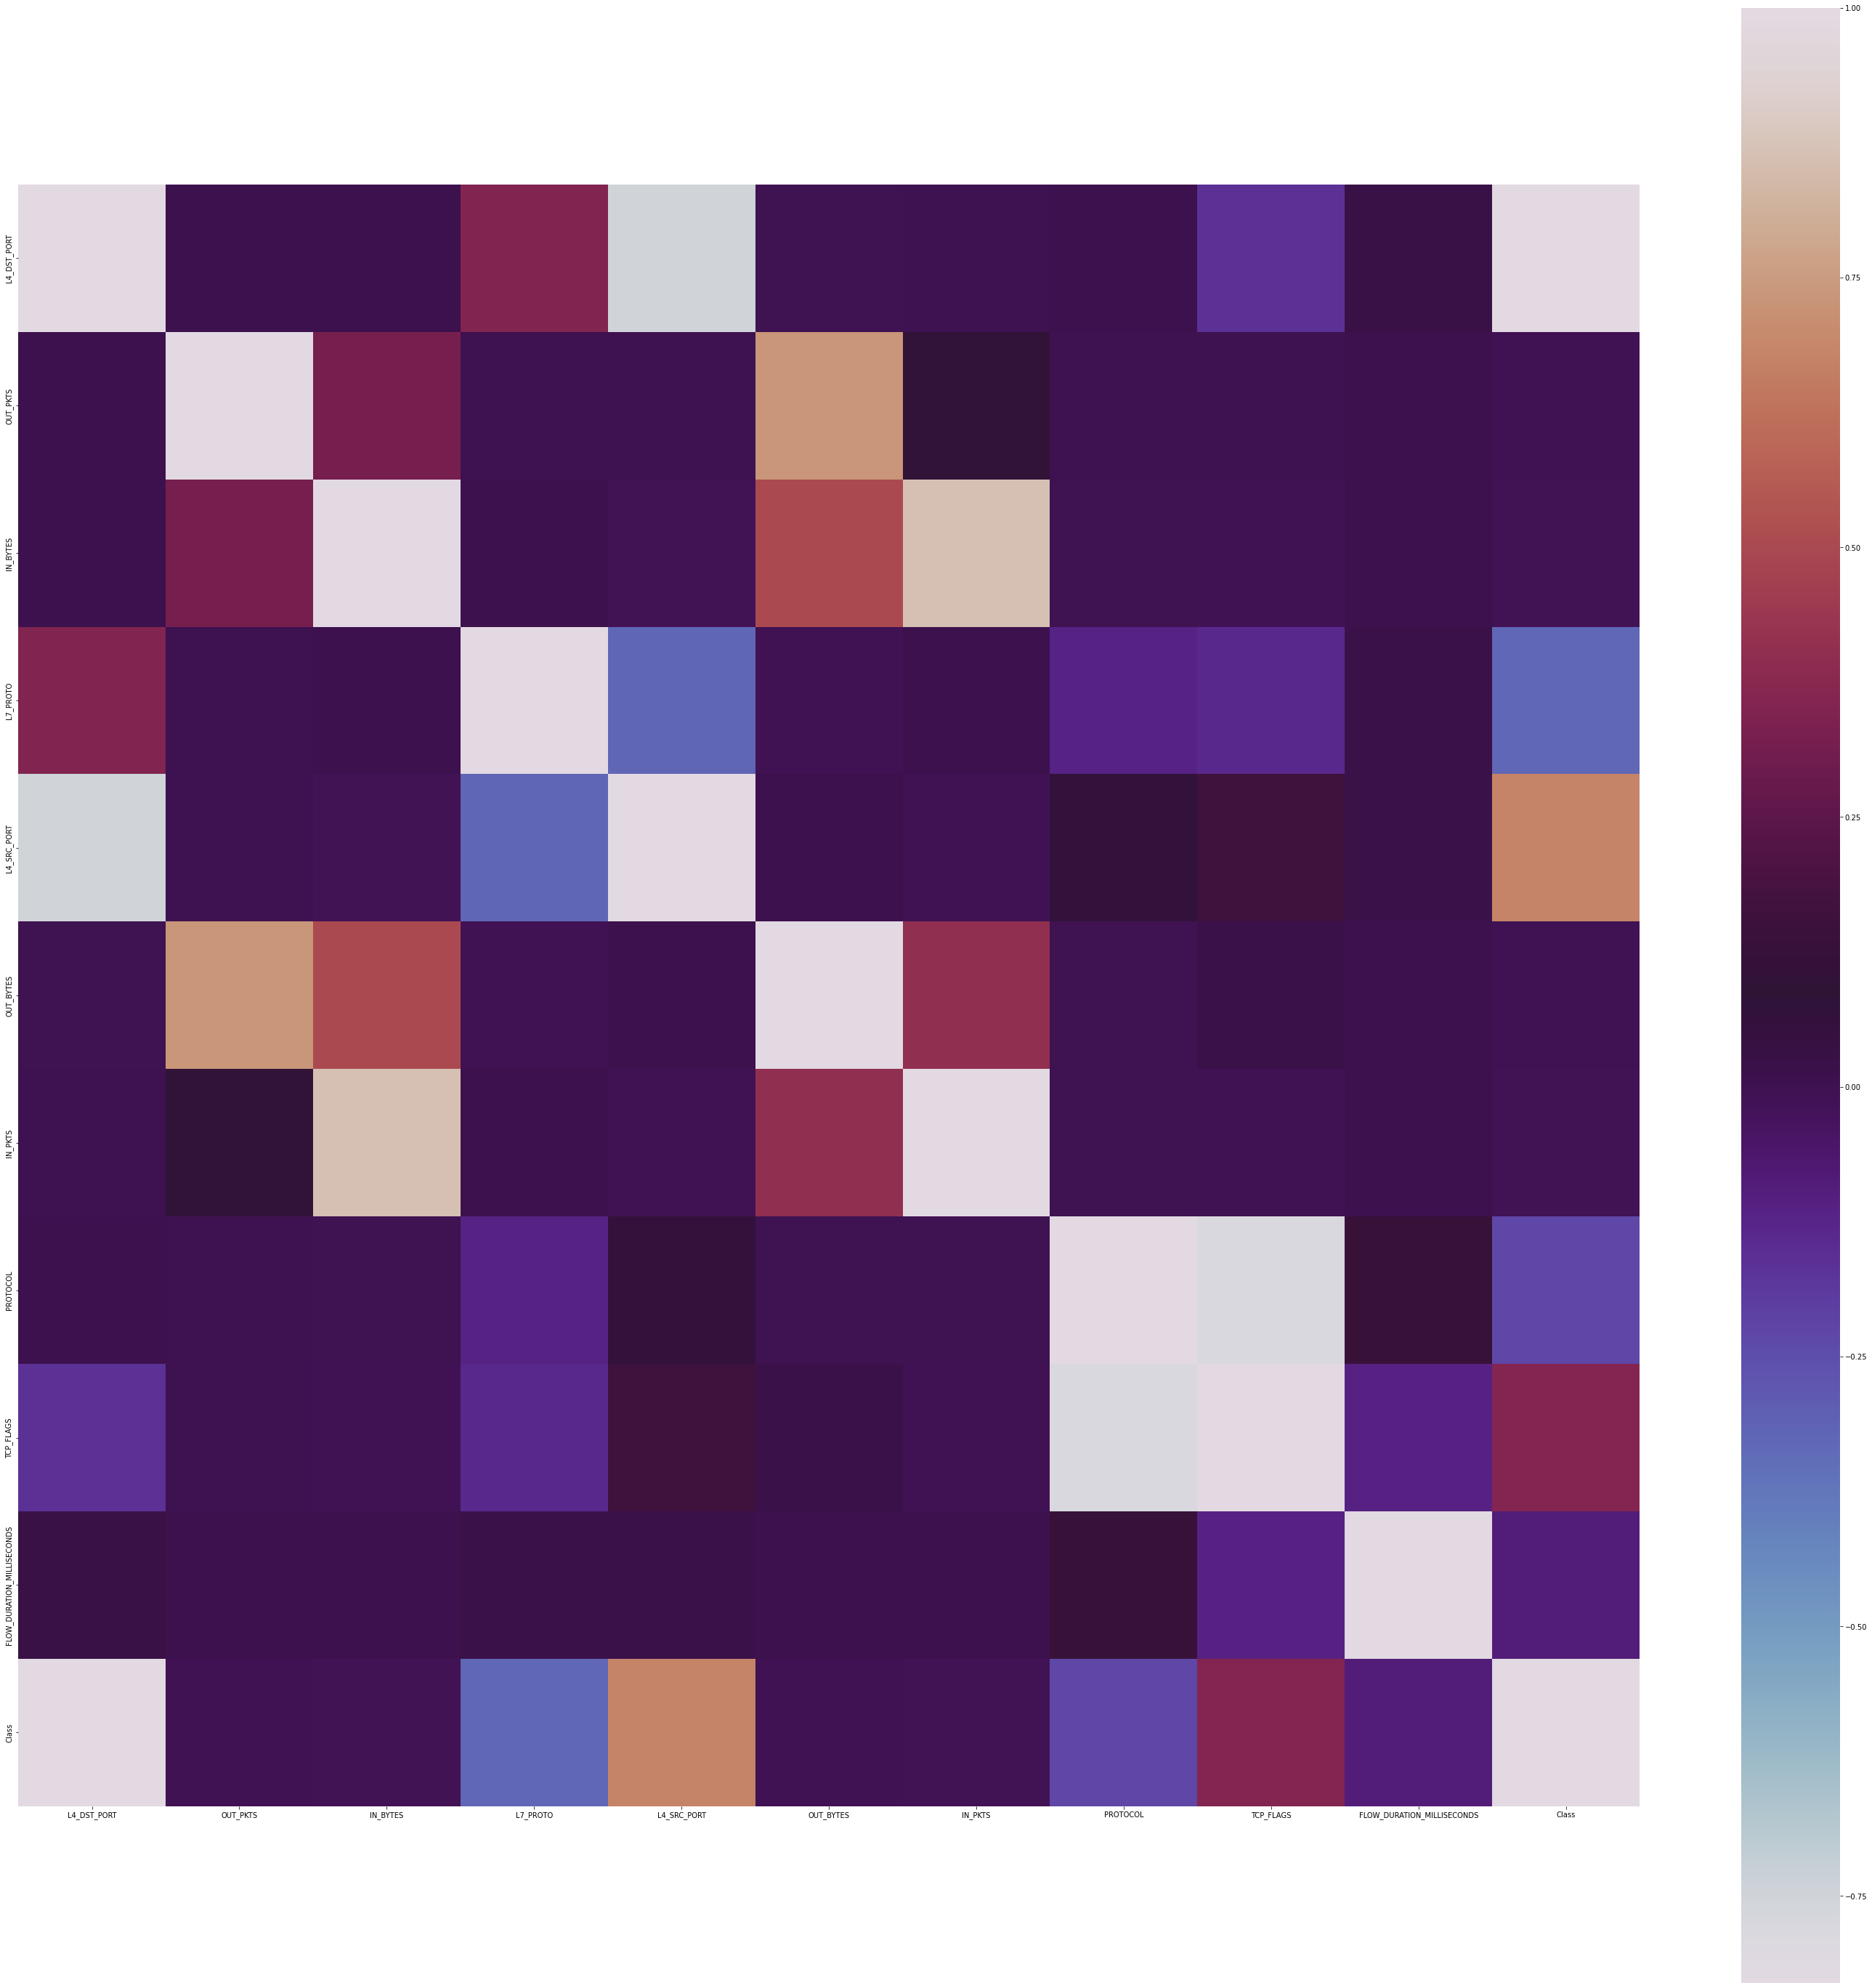

In [15]:
XstdY = data[cols_to_norm].copy()
XstdY['Class'] = data['y']
cormat = XstdY.corr()
fig = plt.figure(figsize=(50,50))

sns.heatmap(cormat, square=True, cmap=plt.cm.twilight)
plt.show()

<AxesSubplot:>

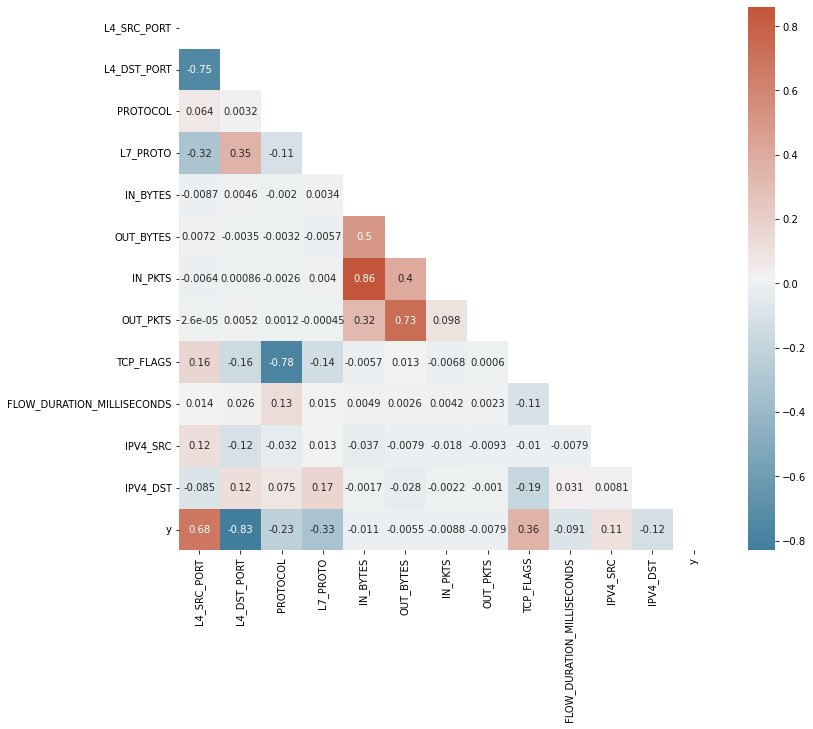

In [16]:

# Correlation between different variables
#
corr = data.corr()
#
# Set up the matplotlib plot configuration
#
f, ax = plt.subplots(figsize=(12, 10))
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)
